<a href="https://colab.research.google.com/github/omg0809/Agent-Motion-Preditction/blob/main/cnn_rnn_agent_motion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install l5kit

In [ ]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "/content/drive/MyDrive/PATH_TO_SAMPLE_DATA"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("/content/drive/MyDrive/PATH_TO_SAMPLE_DATA/config_sample.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 16, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 873, 'eval_every_n_steps': 10000}}


In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, rnn_num_layers=1, input_feature_len=2, sequence_len=50, hidden_size=100, bidirectional=False, device='cuda', rnn_dropout=0.2):
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.gru = nn.GRU(
            input_size=input_feature_len,
            hidden_size=hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        ) 
        self.resnet50_cnn_cell = resnet50(pretrained=True) 
        # Additional layers or modifications to ResNet50 can be added here 
        num_in_channels = 3 
        self.resnet50_cnn_cell.conv1 = nn.Conv2d( 
            num_in_channels, 
            self.resnet50_cnn_cell.conv1.out_channels, 
            kernel_size=self.resnet50_cnn_cell.conv1.kernel_size, 
            stride=self.resnet50_cnn_cell.conv1.stride, 
            padding=self.resnet50_cnn_cell.conv1.padding, 
            bias=False, 
        )  
        num_targets = self.hidden_size 
        self.resnet50_cnn_cell.fc = nn.Linear(in_features=2048, out_features=hidden_size)
        self.hidden_linear = nn.Linear(in_features= 2*hidden_size, out_features = hidden_size)
        self.device = device

    def forward(self, input_seq, data):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2) 
        gru_out, hidden = self.gru(input_seq, ht)
        # print(gru_out.shape) 
        # print(hidden.shape) 
        inputs = data["image"].to(self.device) 
        inputs = inputs[:, :3, :, :] 
        # Forward pass 
        cnn_out = self.resnet50_cnn_cell(inputs)
        if self.rnn_directions * self.num_layers > 1: 
            num_layers = self.rnn_directions * self.num_layers
            if self.rnn_directions > 1: 
                gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
                gru_out = torch.sum(gru_out, axis=2) 
            hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)
            if self.num_layers > 0: 
                hidden = hidden[-1] 
            else:  
                hidden = hidden.squeeze(0) 
            hidden = hidden.sum(axis=0) 
        else:  
            hidden.squeeze_(0)
            # Forward pass 
            hidden_cat = torch.cat((hidden, cnn_out), axis=1)
            context_proj = self.hidden_linear(hidden_cat)

        return gru_out, context_proj


In [ ]:
#the following class represents a decoder cell that will take a sequence of inputs and a hidden state as inputs and returns an (x,y) and another hidden state as output
#the decoder cells can be concatenated together to get as many (x,y)s as desired  
class DecoderCell(nn.Module):
    def __init__(self, input_feature_len = 2, hidden_size = 100, dropout=0.2):
        super().__init__()
        self.decoder_rnn_cell = nn.GRUCell( 
            input_size=input_feature_len, 
            hidden_size=hidden_size, 
        )
        self.out = nn.Linear(hidden_size, 2)
        self.attention = False
        self.dropout = nn.Dropout(dropout)

    def forward(self, prev_hidden, y):
        # print("shape of prev_hidden and y")
        # print(prev_hidden.shape,y.shape)
        rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, encoder, decoder_cell, output_size=50,output_feature_len=2, teacher_forcing=0, sequence_len=50, decoder_input=True, device='cuda'):
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.output_feature_len = output_feature_len
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input 
        self.device = device 
 
    def forward(self, xb, data, yb=None):
        input_seq = xb
        encoder_output, encoder_hidden = self.encoder(input_seq,data) 
        prev_hidden = encoder_hidden
        outputs = torch.zeros(input_seq.size(0), self.output_size, self.output_feature_len, device=self.device)
        y_prev = input_seq[:, -1, :] 
        for i in range(self.output_size): 
            step_decoder_input = y_prev 
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = yb[:, i, :] 
            rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i, :] = rnn_output
        return outputs 

In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    device = 'cuda'

    encoder = RNNEncoder(
        input_feature_len=2, 
        rnn_num_layers=1, 
        hidden_size=100,  
        sequence_len=50,
        bidirectional=False,
        device=device,
        rnn_dropout=0.2
    )

    decoder_cell = DecoderCell(
        input_feature_len=2,
        hidden_size=100,
    )


    loss_function = nn.MSELoss()

    encoder = encoder.to(device)
    decoder_cell = decoder_cell.to(device)

    model = EncoderDecoderWrapper(
        encoder, 
        decoder_cell,
        output_size=50,
        output_feature_len=2,
        teacher_forcing=0,
        sequence_len=50,
        decoder_input=True,
        device='cuda'
    )

    model = model.to(device)

    return model

In [ ]:
def forward(data, model, device, criterion):
    xb = data["history_positions"].to(device)
    # print("shape of x_b")
    # print(xb.shape)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device) 
    yb = data["target_positions"].to(device) 
    # Forward pass 
    outputs = model(xb,data,yb).reshape(yb.shape)
    loss = criterion(outputs, yb)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities 
    loss = loss.mean() 
    return loss, outputs

In [ ]:
# ==== INIT MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none") 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
dataset = AgentDataset(cfg, train_zarr, rasterizer)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset
tr_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(tr_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
test_dataloader = DataLoader(test_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


# Training




In [ ]:
# ==== TRAIN LOOP
num_batch = len(train_dataloader)
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(num_batch))
losses_train = []
avg_loss = []  
for _ in progress_bar: 
    try: 
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    avg_loss.append(np.mean(losses_train))
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 182.43727111816406 loss(avg): 90.19427353386666: 100%|██████████| 6280/6280 [52:23<00:00,  2.00it/s]


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/MODEL/trained_cnn_rnn.pth"
torch.save(model.state_dict(),SAVE_PATH)

In [ ]:
avg_loss = avg_loss[25:]

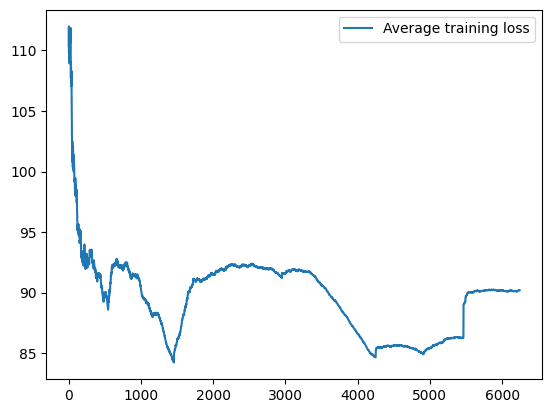

In [ ]:
plt.plot(np.arange(len(avg_loss)), avg_loss, label="Average training loss")
plt.legend()
plt.show()

### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
tr_it = iter(test_dataloader)
progress_bar = tqdm(range(len(test_dataloader)))
model.eval()
torch.set_grad_enabled(False)
losses_test = []
avgTest_loss = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    loss, _ = forward(data, model, device, criterion)
    losses_test.append(loss.item())
    avgTest_loss.append(np.mean(losses_test))
    progress_bar.set_description(f"Batch loss: {loss.item()} loss(avg): {np.mean(losses_test)}")

Batch loss: 76.29520416259766 loss(avg): 90.07993379499987: 100%|██████████| 698/698 [05:52<00:00,  1.98it/s]


In [ ]:
plt.plot(np.arange(len(avgTest_loss)), avgTest_loss, label="Average testing loss")
plt.legend()
plt.show()

[[0. 0.]]
(50, 2)


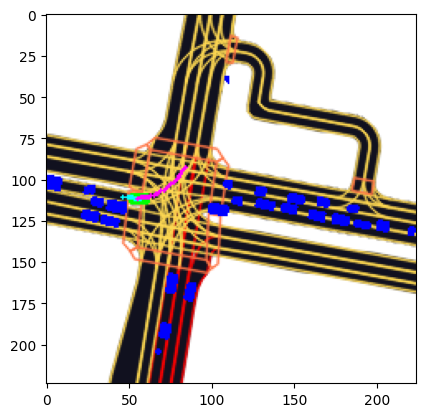

In [ ]:
sample_idx = np.random.randint(0,100)
sample_data = test_dataset[sample_idx]
print(sample_data["history_positions"])
img = sample_data["image"].transpose(1,2,0)
img = dataset.rasterizer.to_rgb(img)

target_positions = sample_data["target_positions"]
# out_net = model(torch.from_numpy(sample_data["image"]).unsqueeze(0).to(device))
# out_net = model(xb=torch.from_numpy(sample_data["history_positions"]),data=torch.from_numpy(sample_data["image"]),yb=torch.from_numpy(sample_data["target_positions"]).unsqueeze(0).to(device))
_, out_net = forward(data,model,device,criterion)
out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
print(out_pos.shape)

predicted_positions = []
target_positions = []
# store absolute world coordinates
predicted_positions.append(transform_points(out_pos, sample_data["world_from_agent"]))
# retrieve target positions from the GT and store as absolute coordinates
#target_positions.append(sample_data['target_positions'] + sample_data["centroid"][:2])
target_positions.append(transform_points(sample_data['target_positions'], sample_data["world_from_agent"]))

predicted_positions = transform_points(np.concatenate(predicted_positions), sample_data["raster_from_world"])
target_positions = transform_points(np.concatenate(target_positions), sample_data["raster_from_world"])

draw_trajectory(img, predicted_positions, PREDICTED_POINTS_COLOR)
draw_trajectory(img, target_positions, TARGET_POINTS_COLOR)

plt.imshow(img)
plt.show()